# DREAM Preterm Birth Prediction challenge

This is analysis of data competition "DREAM Preterm Birth Prediction challenge". The goal is to predict the gestational age, the months from the last period after pregnancy and the child birth, based on the blood genome data. The main difficulty is to extract important features from the data, which has 30,000 columns.

# Package

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statistics
import math
import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers

# Data 

The following data was preprocessed in R, by merging eset_HTA20 and anoSC1_v11_nokey.csv. It contains both train and test observations.

In [2]:
alldata = pd.read_csv("alldata.csv")
alldata.head()

,Unnamed: 0,g_1,g_2,g_3,g_4,g_5,g_6,g_7,g_8,g_9,...,g_32827,g_32828,g_32829,g_32830,SampleID,GA,Batch,Set,Train,Platform
0,1,6.062215,3.796484,5.849338,3.567779,6.166815,4.443027,5.836522,6.330018,4.922339,...,8.972873,10.440245,12.101476,13.695705,Tarca_001_P1A01,11.0,1,PRB_HTA,1,HTA20
1,2,6.125023,3.805305,6.191562,3.452524,5.678373,4.773199,6.143398,5.601745,4.711765,...,9.376194,10.845176,12.370891,13.635522,Tarca_003_P1A03,NaN,1,PRB_HTA,0,HTA20
2,3,5.875502,3.450245,6.550525,3.316134,6.185059,4.393488,5.898364,6.137984,4.628124,...,8.843612,10.493416,12.295786,13.616688,Tarca_004_P1A04,32.6,1,PRB_HTA,1,HTA20
3,4,6.126131,3.628411,6.421877,3.432451,5.633757,4.623783,6.019792,5.787502,4.796283,...,9.191471,10.879879,12.249936,13.524328,Tarca_005_P1A05,30.6,1,PRB_HTA,1,HTA20
4,5,6.146466,3.446812,6.260962,3.477162,5.313198,4.422651,6.407699,5.830437,4.726488,...,9.247768,10.754316,12.245458,13.509353,Tarca_006_P1A06,NaN,1,PRB_HTA,0,HTA20


# Train and test split

In [3]:
X_train_df = alldata.loc[alldata['Train'] == 1, 'g_1':'g_32830']
y_train_df = alldata.loc[alldata['Train'] == 1, 'GA']
X_test_df = alldata.loc[alldata['Train'] == 0, 'g_1':'g_32830']
ID_test_df = alldata.loc[alldata['Train'] == 0, 'SampleID']
print("X_train dimension:", X_train_df.shape)
print("y_train dimension:", y_train_df.shape)
print("X_test dimension:", X_test_df.shape)

X_train dimension: (367, 32830)
y_train dimension: (367,)
X_test dimension: (368, 32830)


# EDA

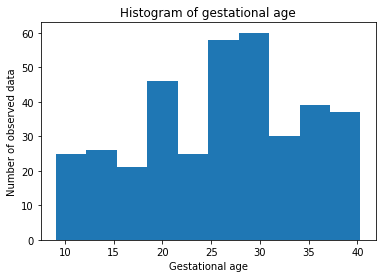

In [4]:
_ = plt.hist(y_train_df)
_ = plt.xlabel("Gestational age")
_ = plt.ylabel("Number of observed data")
_ = plt.title("Histogram of gestational age")
plt.show()

# Hyperparameter tuning with GridSearchCV

Use GridSearchCV and apply 10-fold cross valadation to tune alpha parameter of lasso.

In [5]:
k = 10
alpha_lower = 0.01
alpha_upper = 0.1

# Setup the parameter grid
alpha_space = np.arange(alpha_lower, alpha_upper, 0.01)
param_grid = {'alpha':alpha_space}

# Instantiate a lasso regression
lasso = Lasso(normalize = True)

# Instantiate the GridSearchCV object
lasso_cv = GridSearchCV(lasso, param_grid, cv = k)

# Fit it to data
lasso_cv.fit(X_train_df.values, y_train_df.values)

# Calculate training accuracy by RMSE
y_pred = lasso_cv.predict(X_train_df.values)
rmse = math.sqrt(statistics.mean((y_train_df.values - y_pred)**2))

# Predictors
best_alpha = lasso_cv.best_params_['alpha']
lasso = Lasso(alpha = best_alpha, normalize = True)
lasso.fit(X_train_df.values, y_train_df.values)
lasso_coef = lasso.coef_
p = sum(abs(lasso_coef) > 0)

# Print the tuned parameters and score
print("Tuned lasso regression hyperparameters: {}".format(lasso_cv.best_params_))
print("Best score: {0:.2f}".format(lasso_cv.best_score_))
print("RMSE: {0:.2f}".format(rmse))
print("Number of predictors: {}".format(p))

C:\Users\yukic\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Tuned lasso regression hyperparameters: {'alpha': 0.04}
Best score: 0.37
RMSE: 5.25
Number of predictors: 59


The above allows us to have the best alpha hyperparameter which acchieve the best accuracy in the validation dataset, and RMSE improved. But we still have 59 predictors and we might have overfitting, and I want to reduce the number of predictors further.

# Correlation among predictors after Lasso

Since the number of predictor is large, I suspect that we have multicolinearity among them, so I check their correlation.

In [15]:
COLUMNS = X_train_df.columns
var = pd.Series(COLUMNS[abs(lasso_coef) > 0])
coef = pd.Series(lasso_coef[abs(lasso_coef) > 0])
lasso_result = pd.concat(objs = [var, coef],
                         axis = 1,
                         keys = ['Variable', 'Lasso_coefficient'])
print(lasso_result.iloc[0:5,:])

  Variable  Lasso_coefficient
0    g_966           0.029606
1   g_1096          -0.611407
2   g_3102           1.309736
3   g_3825          -0.389717
4   g_4092           0.142927


In [7]:
COLUMNS = lasso_result['Variable'].tolist()
corrmat = X_train_df[COLUMNS].corr()
corrmat = corrmat.rename_axis(None).rename_axis(None, axis = 1)
corrmat = corrmat.stack().reset_index()
corrmat.columns = ['var_1', 'var_2', 'correlation']
corrmat = corrmat[corrmat['correlation'] != 1]
corrmat.sort_values(by = 'correlation', ascending = False).head(5)

,var_1,var_2,correlation
3114,g_28122,g_26873,0.724736
2766,g_26873,g_28122,0.724736
2170,g_22398,g_26873,0.664767
2750,g_26873,g_22398,0.664767
3220,g_29804,g_22158,0.627796


Some has high correlation. Next, we check the p-values of those predictors.

# p-values of predictos of Lasso variable selection

In [8]:
COLUMNS = lasso_result['Variable'].tolist()
X = X_train_df[COLUMNS].values
X = sm.add_constant(X)
y = y_train_df.values
result = sm.OLS(y, X).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.782
Model:                            OLS   Adj. R-squared:                  0.740
Method:                 Least Squares   F-statistic:                     18.68
Date:                Sat, 20 Jul 2019   Prob (F-statistic):           4.14e-72
Time:                        15:07:25   Log-Likelihood:                -1021.3
No. Observations:                 367   AIC:                             2163.
Df Residuals:                     307   BIC:                             2397.
Df Model:                          59                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -171.2488     69.502     -2.464      0.0

So it shows that we can do variable selection by lasso regression and reduced the dimension from 30,000 to 50~80 smaller subset. But when you make an ordinary least squares regression, we still have many non-significant predictor. Drop predictors which has high p-values. We implement backwards elimination procedure.

# Estimate best number of predictors

Prepare validation data to check the accuracy according to the number of predictors.

In [38]:
TEST_SIZE = 0.33
SEED = 42

# split to training and validation
X_train, X_vali, y_train, y_vali = train_test_split(X_train_df, y_train_df, test_size = TEST_SIZE, random_state = SEED)

In [39]:
print(X_train.shape)
print(y_train.shape)
print(X_vali.shape)
print(y_vali.shape)

(245, 32830)
(245,)
(122, 32830)
(122,)


Function to extract OLS summary information

In [40]:
def results_summary_to_dataframe(results):
    '''take the result of an statsmodel results table and transforms it into a dataframe'''
    coeff = results.params
    pvals = results.pvalues
    conf_lower = results.conf_int()[:,0]
    conf_higher = results.conf_int()[:,1]

    results_df = pd.DataFrame({"coeff":coeff,
                               "pvals":pvals,
                               "conf_lower":conf_lower,
                               "conf_higher":conf_higher
                                })
    return results_df

# Backwards elimination procedure

In backwards elimination, in the end, we want only predictors which are significant. However, at the same time, we want to know the best number of predictors from validation data.

In [41]:
# initial variables
COLUMNS = np.array(lasso_result['Variable'])

# store validation result
n = len(COLUMNS)
rmse_list = np.zeros(n)
p_list = np.zeros(n)
max_pval_list = np.zeros(n)

for i in range(n):
    
    # run OLS regression
    X = X_train[COLUMNS].values
    X = sm.add_constant(X)
    y = y_train.values
    result = sm.OLS(y, X).fit()

    # predict validation accuracy
    X = X_vali[COLUMNS].values
    X = sm.add_constant(X)
    y_vali_pred = result.predict(X)
    rmse = math.sqrt(statistics.mean((y_vali - y_vali_pred)**2))
    rmse_list[i] = rmse
    
    # store number of predictors
    p_list[i] = len(COLUMNS)
    
    # extract ols results
    result_df = results_summary_to_dataframe(result)

    # Adding Intercept label
    COLUMNS_int = COLUMNS.copy()
    COLUMNS_int = np.append('Intercept', COLUMNS_int)
    result_df['predictors'] = COLUMNS_int
    
    # delete one predictor
    result_nonint = result_df.copy()
    result_nonint = result_nonint.drop(0, axis = 0) # delete intercept row
    max_pval_list[i] = max(result_nonint['pvals']) # store max p-value
    idx_del = result_nonint['pvals'].idxmax()
    result_nonint = result_nonint.drop(idx_del, axis = 0)

    # store list of predictors after drop one predictors
    COLUMNS = np.array(result_nonint['predictors'])

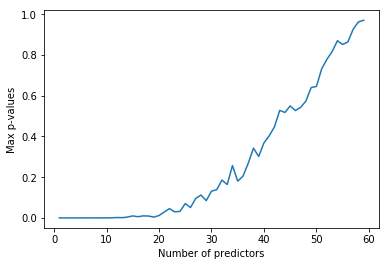

In [42]:
_ = plt.plot(p_list, max_pval_list)
_ = plt.xlabel('Number of predictors')
_ = plt.ylabel('Max p-values')
plt.show()

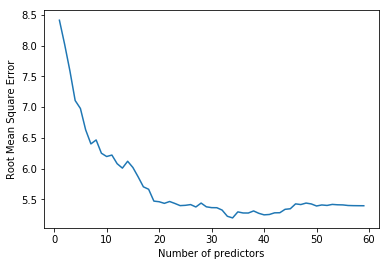

In [43]:
_ = plt.plot(p_list, rmse_list)
_ = plt.xlabel('Number of predictors')
_ = plt.ylabel('Root Mean Square Error')
plt.show()

In [44]:
best = np.where(rmse_list == min(rmse_list))
print("Number of predictors: {}".format(p_list[best]))
print("Max p-value: {}".format(np.round(max_pval_list[best], decimals = 3)))

Number of predictors: [34.]
Max p-value: [0.257]


Even though we achieve the best accuracy in the test set by backwards elimination, it does not mean that we only have significant predictors. We improve the procedure. Make while roop to have only significant predictors in the last model.

# Backwards elimination with p-value control

In [88]:
# initial values
COLUMNS = np.array(lasso_result['Variable'])
X_train = X_train_df # we don't use validation set to check accuracy
y_train = y_train_df
p_max = 1.0
i = 0 # counter

# store validation result
n = len(COLUMNS)
p_list = np.zeros(n)
max_pval_list = np.zeros(n)

# threshold of p-value
p_threshold = 0.00001

while p_max > p_threshold:
       
    # run OLS regression
    X = X_train[COLUMNS].values
    X = sm.add_constant(X)
    y = y_train.values
    result = sm.OLS(y, X).fit()
    
    # store number of predictors
    p_list[i] = len(COLUMNS)
    
    # extract ols results
    result_df = results_summary_to_dataframe(result)

    # Adding Intercept label
    COLUMNS_int = COLUMNS.copy()
    COLUMNS_int = np.append('Intercept', COLUMNS_int)
    result_df['predictors'] = COLUMNS_int
    
    # check max p-value
    result_nonint = result_df.copy()
    result_nonint = result_nonint.drop(0, axis = 0) # delete intercept row
    max_pval_list[i] = max(result_nonint['pvals']) # store max p-value
    p_max = max(result_nonint['pvals'])
    
    # delete one predictor
    idx_del = result_nonint['pvals'].idxmax()
    result_nonint = result_nonint.drop(idx_del, axis = 0)

    # store list of predictors after drop one predictors
    COLUMNS = np.array(result_nonint['predictors'])
    
    # counter plus one
    i = i + 1

In [89]:
np.round(p_max, decimals = 5)

1e-05

In [90]:
p_list

array([59., 58., 57., 56., 55., 54., 53., 52., 51., 50., 49., 48., 47.,
       46., 45., 44., 43., 42., 41., 40., 39., 38., 37., 36., 35., 34.,
       33., 32., 31., 30., 29., 28., 27., 26., 25., 24., 23., 22., 21.,
       20., 19., 18., 17., 16., 15., 14., 13., 12., 11., 10.,  9.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [91]:
np.round(max_pval_list, decimals = 3)

array([0.998, 0.97 , 0.871, 0.848, 0.813, 0.778, 0.754, 0.728, 0.733,
       0.631, 0.566, 0.517, 0.434, 0.414, 0.362, 0.396, 0.422, 0.314,
       0.285, 0.266, 0.272, 0.259, 0.141, 0.13 , 0.125, 0.135, 0.115,
       0.073, 0.111, 0.095, 0.082, 0.073, 0.04 , 0.028, 0.011, 0.011,
       0.007, 0.011, 0.013, 0.003, 0.003, 0.001, 0.001, 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   ])

In [92]:
np.round(result_df, decimals = 4)

,coeff,pvals,conf_lower,conf_higher,predictors
0,-195.7002,0.0,-253.2966,-138.1037,Intercept
1,6.9224,0.0,3.9407,9.9041,g_5745
2,1.3357,0.0,0.7600,1.9115,g_10446
3,-9.1096,0.0,-11.3763,-6.8428,g_17724
4,-15.3145,0.0,-20.8790,-9.7499,g_25719
5,10.1441,0.0,8.5728,11.7154,g_26984
6,10.4892,0.0,5.9002,15.0782,g_27948
7,3.8711,0.0,2.9293,4.8130,g_28122
8,13.7469,0.0,8.2776,19.2163,g_28914
9,15.1490,0.0,12.2797,18.0184,g_29804


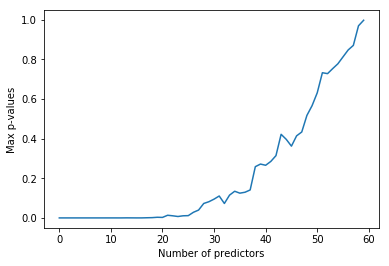

In [80]:
_ = plt.plot(p_list, max_pval_list)
_ = plt.xlabel('Number of predictors')
_ = plt.ylabel('Max p-values')
plt.show()

In [82]:
result_df['predictors']

0    Intercept
1       g_5745
2      g_10446
3      g_17724
4      g_25719
5      g_26984
6      g_27948
7      g_28122
8      g_28914
9      g_29804
Name: predictors, dtype: object

Now the number of predictors are 9, and I conclude this is reasonable number of predictors, so use them to predict test set.

# Prediction of training dataset

In [95]:
COLUMNS_final = np.array(result_df['predictors'].drop(0, axis = 0))
COLUMNS_final

array(['g_5745', 'g_10446', 'g_17724', 'g_25719', 'g_26984', 'g_27948',
       'g_28122', 'g_28914', 'g_29804'], dtype=object)

In [96]:
X = X_train_df[COLUMNS_final].values
X = sm.add_constant(X)
y = y_train_df.values
model = sm.OLS(y, X).fit()
y_train_pred = model.predict(X)

# Calculate accuracy
rmse = math.sqrt(statistics.mean((y - y_train_pred)**2))
print("RMSE of training: {:5.2f}".format(rmse))

RMSE of training:  5.46


# Prediction of test dataset

In [97]:
X_test = X_test_df[COLUMNS_final].values
X_test = sm.add_constant(X_test)
test_pred = model.predict(X_test).round(1) # DREAM allows only 1 decimal point
result = pd.concat([pd.Series(ID_test_df.values), pd.Series(test_pred)],
                  axis = 1,
                  keys = ['SampleID', 'GA'])
result.head()

,SampleID,GA
0,Tarca_003_P1A03,22.3
1,Tarca_006_P1A06,22.2
2,Tarca_011_P1A11,20.1
3,Tarca_012_P1A12,37.5
4,Tarca_015_P1B03,26.6


In [100]:
result.describe()

,GA
count,368.000000
mean,26.677989
std,7.252351
min,7.300000
25%,21.400000
50%,26.550000
75%,32.225000
max,50.100000


# Adjustment

DREAM suggests that values are expected to be >8 and <42, so adjusts predicted values.
<br>
https://www.synapse.org/#!Synapse:syn18380862/wiki/590817

In [101]:
print((result['GA'] >= 42).sum())
print((result['GA'] <= 8).sum())

4
1


In [102]:
result.loc[result['GA'] >= 42, 'GA'] = 41.9
result.loc[result['GA'] <= 8, 'GA'] = 8.1

In [103]:
result['GA'].describe()

count    368.000000
mean      26.636413
std        7.135365
min        8.100000
25%       21.400000
50%       26.550000
75%       32.225000
max       41.900000
Name: GA, dtype: float64

# Submission

In [104]:
sub = result
# sub.to_csv('C:\\Users\\yukic\\Documents\\DREAM\\submission_190707.csv', index = False)
# sub.to_csv('C:\\Users\\yukic\\Documents\\DREAM\\submission_190712.csv', index = False)
# sub.to_csv('C:\\Users\\yukic\\Documents\\DREAM\\submission_190720.csv', index = False)